In [6]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import markdown 


import torch
import selfies as sf
import sentencepiece as spm

from FingerprintDecoder.utils import *
from FingerprintDecoder.predict import *
from FingerprintDecoder.parameters import *
from FingerprintDecoder.interpretability import *
from FingerprintDecoder.fingerprints import *

root_dir = './'

In [7]:

class Args:
    fp = 'AEs'
    model_type = 'smiles'
    src_vocab_size = fp_vocab_sizes[fp]
    trg_vocab_size = trg_vocab_sizes[model_type]
    src_seq_len = fp_seq_lens[fp]
    trg_seq_len = trg_seq_len

    fp_datadir = data_dir.joinpath('fingerprints', fp)

    src_sp_prefix = f"{sp_dir}/{fp}_{SP_NAME}"
    trg_sp_prefix = f"{sp_dir}/{model_type}_{SP_NAME}"

    rank  = torch.device('cuda')  if torch.cuda.is_available() else torch.device('cpu')
    device = rank
    checkpoint = f"{ckpt_dir}/{fp}_{model_type}_checkpoint.pth"

    
args = Args



##  Build and setup model

In [8]:
model = setup(build_model(args), args.checkpoint, args)

The size of src vocab is 67214 and that of trg vocab is 109.
Loading checkpoint... AEs smiles


## Example for AEs

In [9]:
src = '198706261 271903915 572760528 848127915 864942730 864942795 1016841875 1428903162 1510461303 2041434490 2092489639 2245384272 2257970297 2378775366 2378779377 2434373675 2530048747 2909042096 3217380708 3218693969 3777168895'
trg = 'C 1 = C ( C = N N 1 C C C Cl ) [N+] ( = O ) [O-]'


# Attention 

Preprocessing input sentence...
Encoding input sentence...
Greedy decoding selected.

Input: 198706261 271903915 572760528 848127915 864942730 864942795 1016841875 1428903162 1510461303 2041434490 2092489639 2245384272 2257970297 2378775366 2378779377 2434373675 2530048747 2909042096 3217380708 3218693969 3777168895
Result: C 1 = C ( C = N N 1 C C C Cl ) [N+] ( = O ) [O-]
Inference finished! || Total inference time: 0mins 0secs


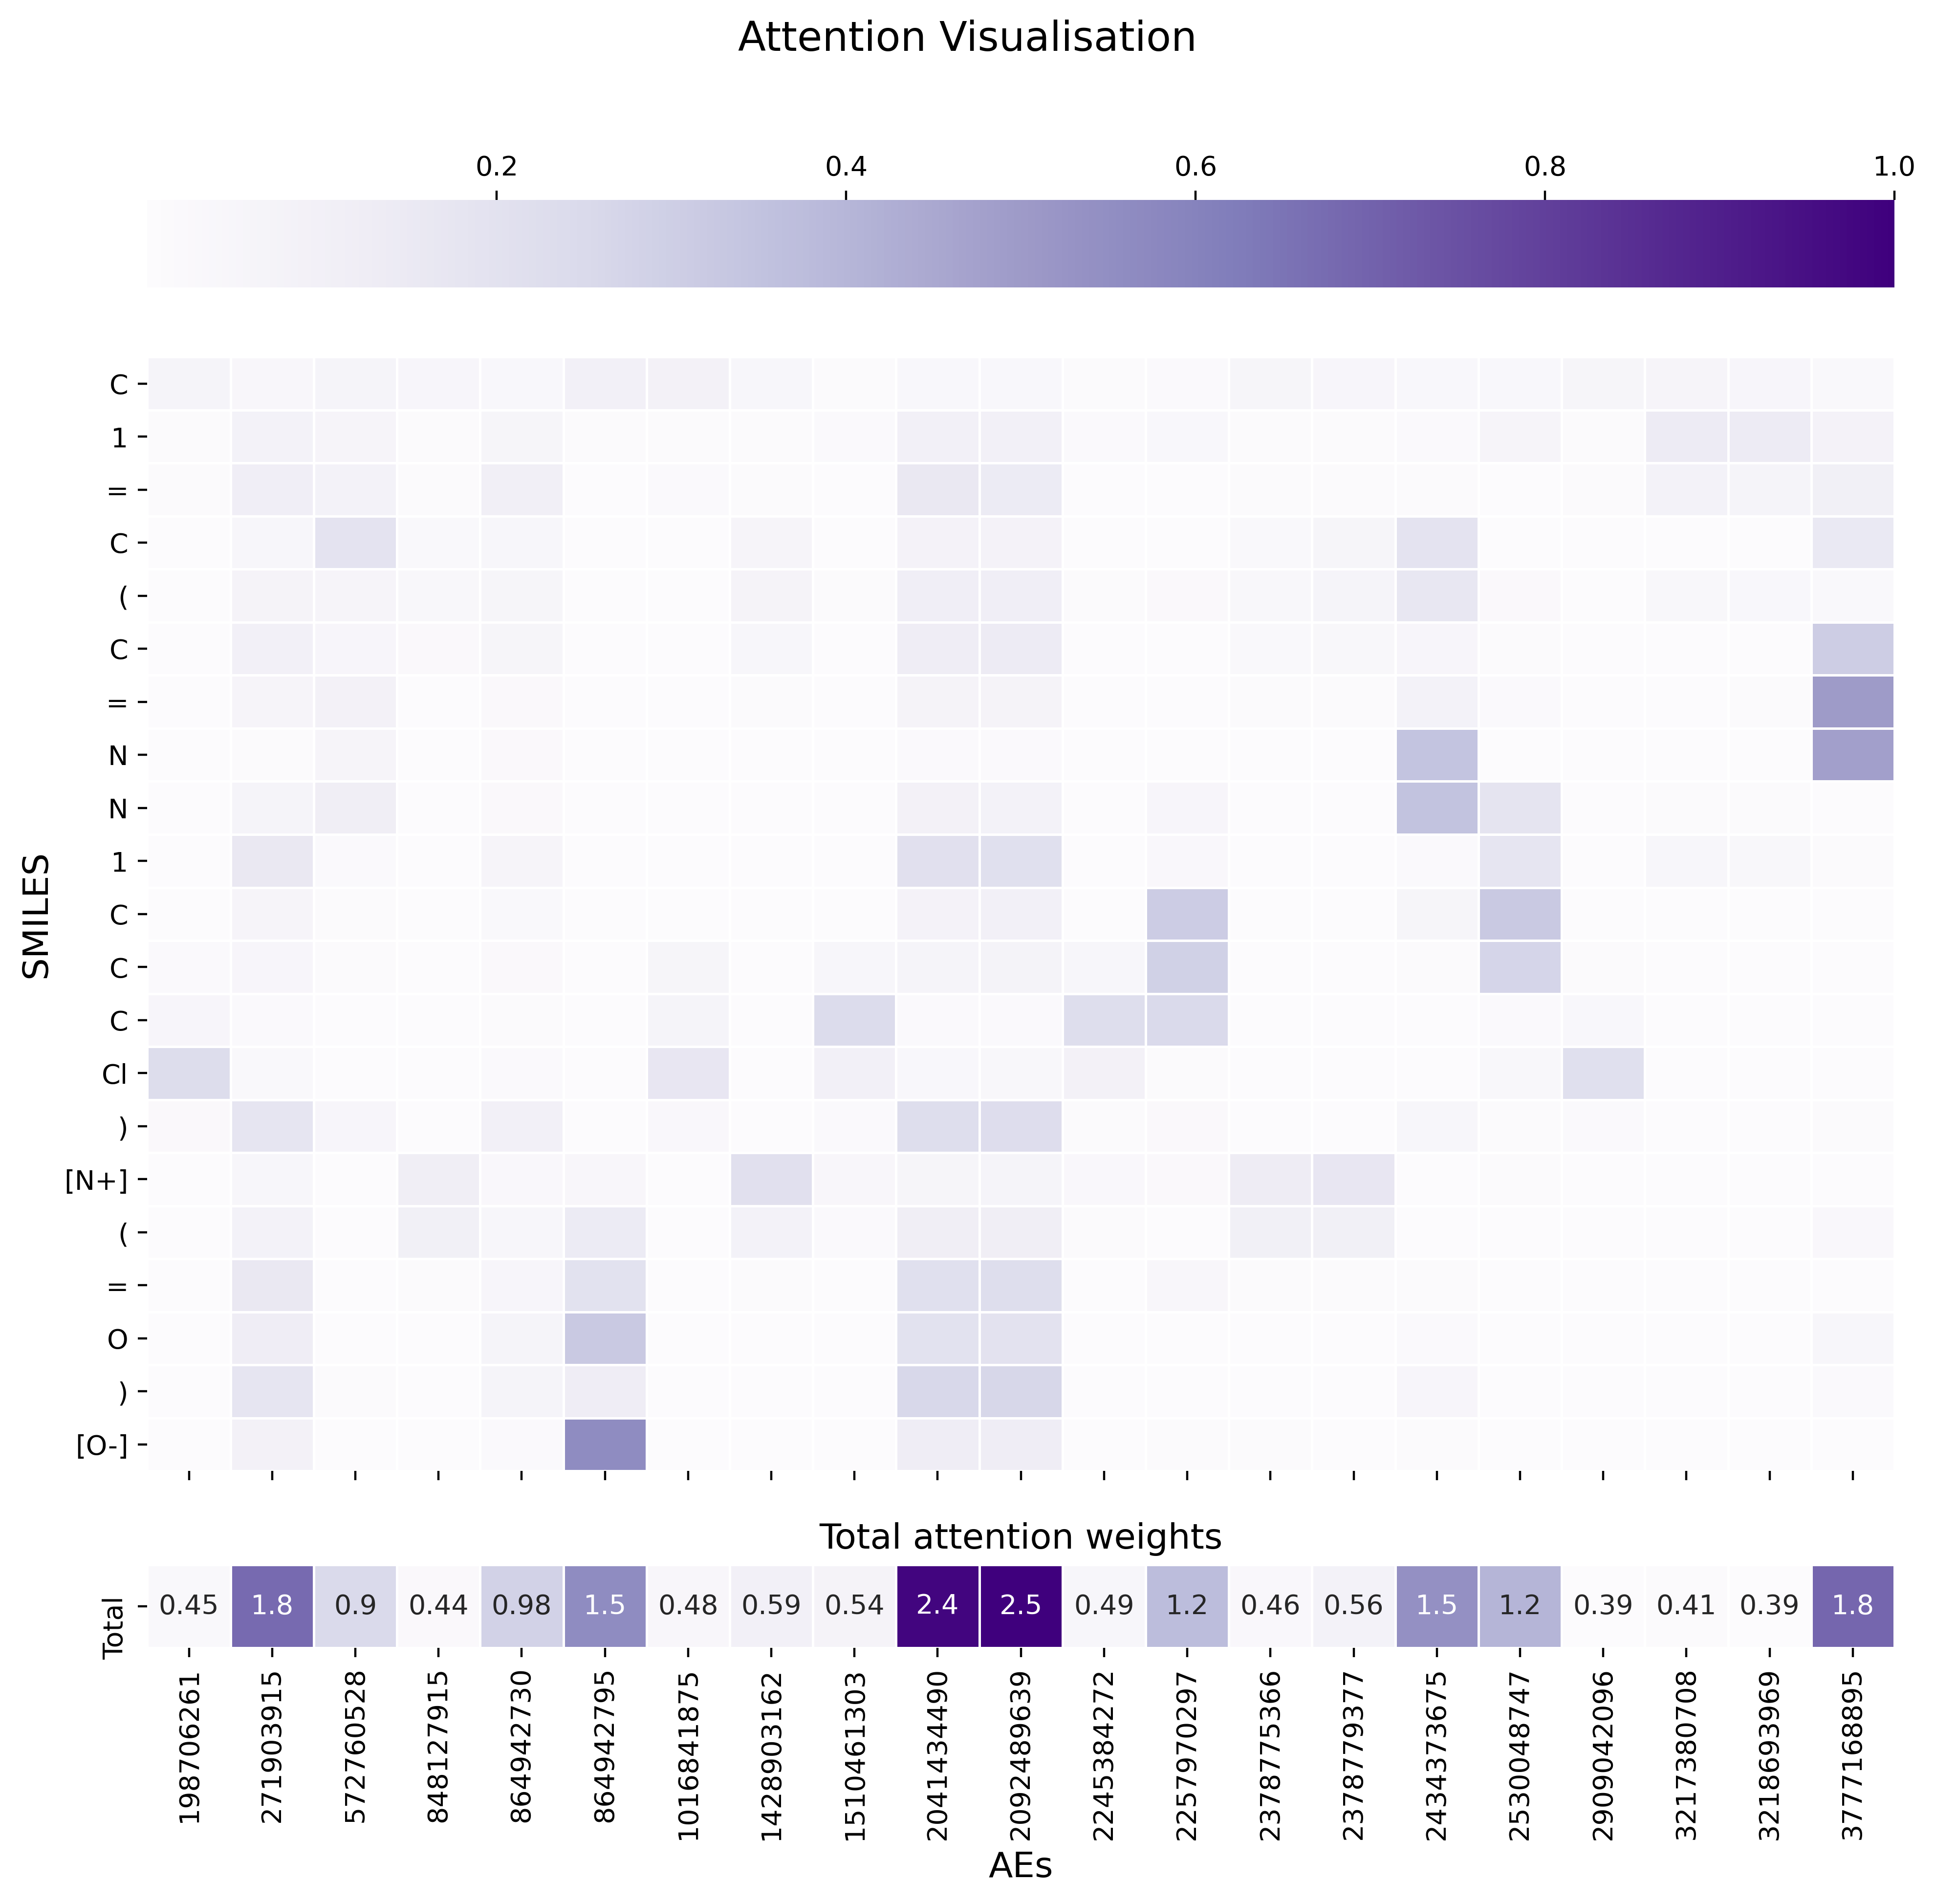

In [10]:
predicted, attn_weight = inference(model, src, method='greedy', args=args, return_attn=True)
attn = (attn_weight.sum(dim=1) / num_heads).squeeze()[:len(predicted.split()), :(len(src.split()))].cpu().detach().numpy() #.shape

attnfig = Attn_plot(src, predicted, attn, 'AEs', 'SMILES', savefig=False, return_fig=True)
# attnfig = Attn_plot(src, predicted, attn, 'AEs', 'SMILES', f"Attention.png", return_fig=True)


##  Integrated Gradients (IG)

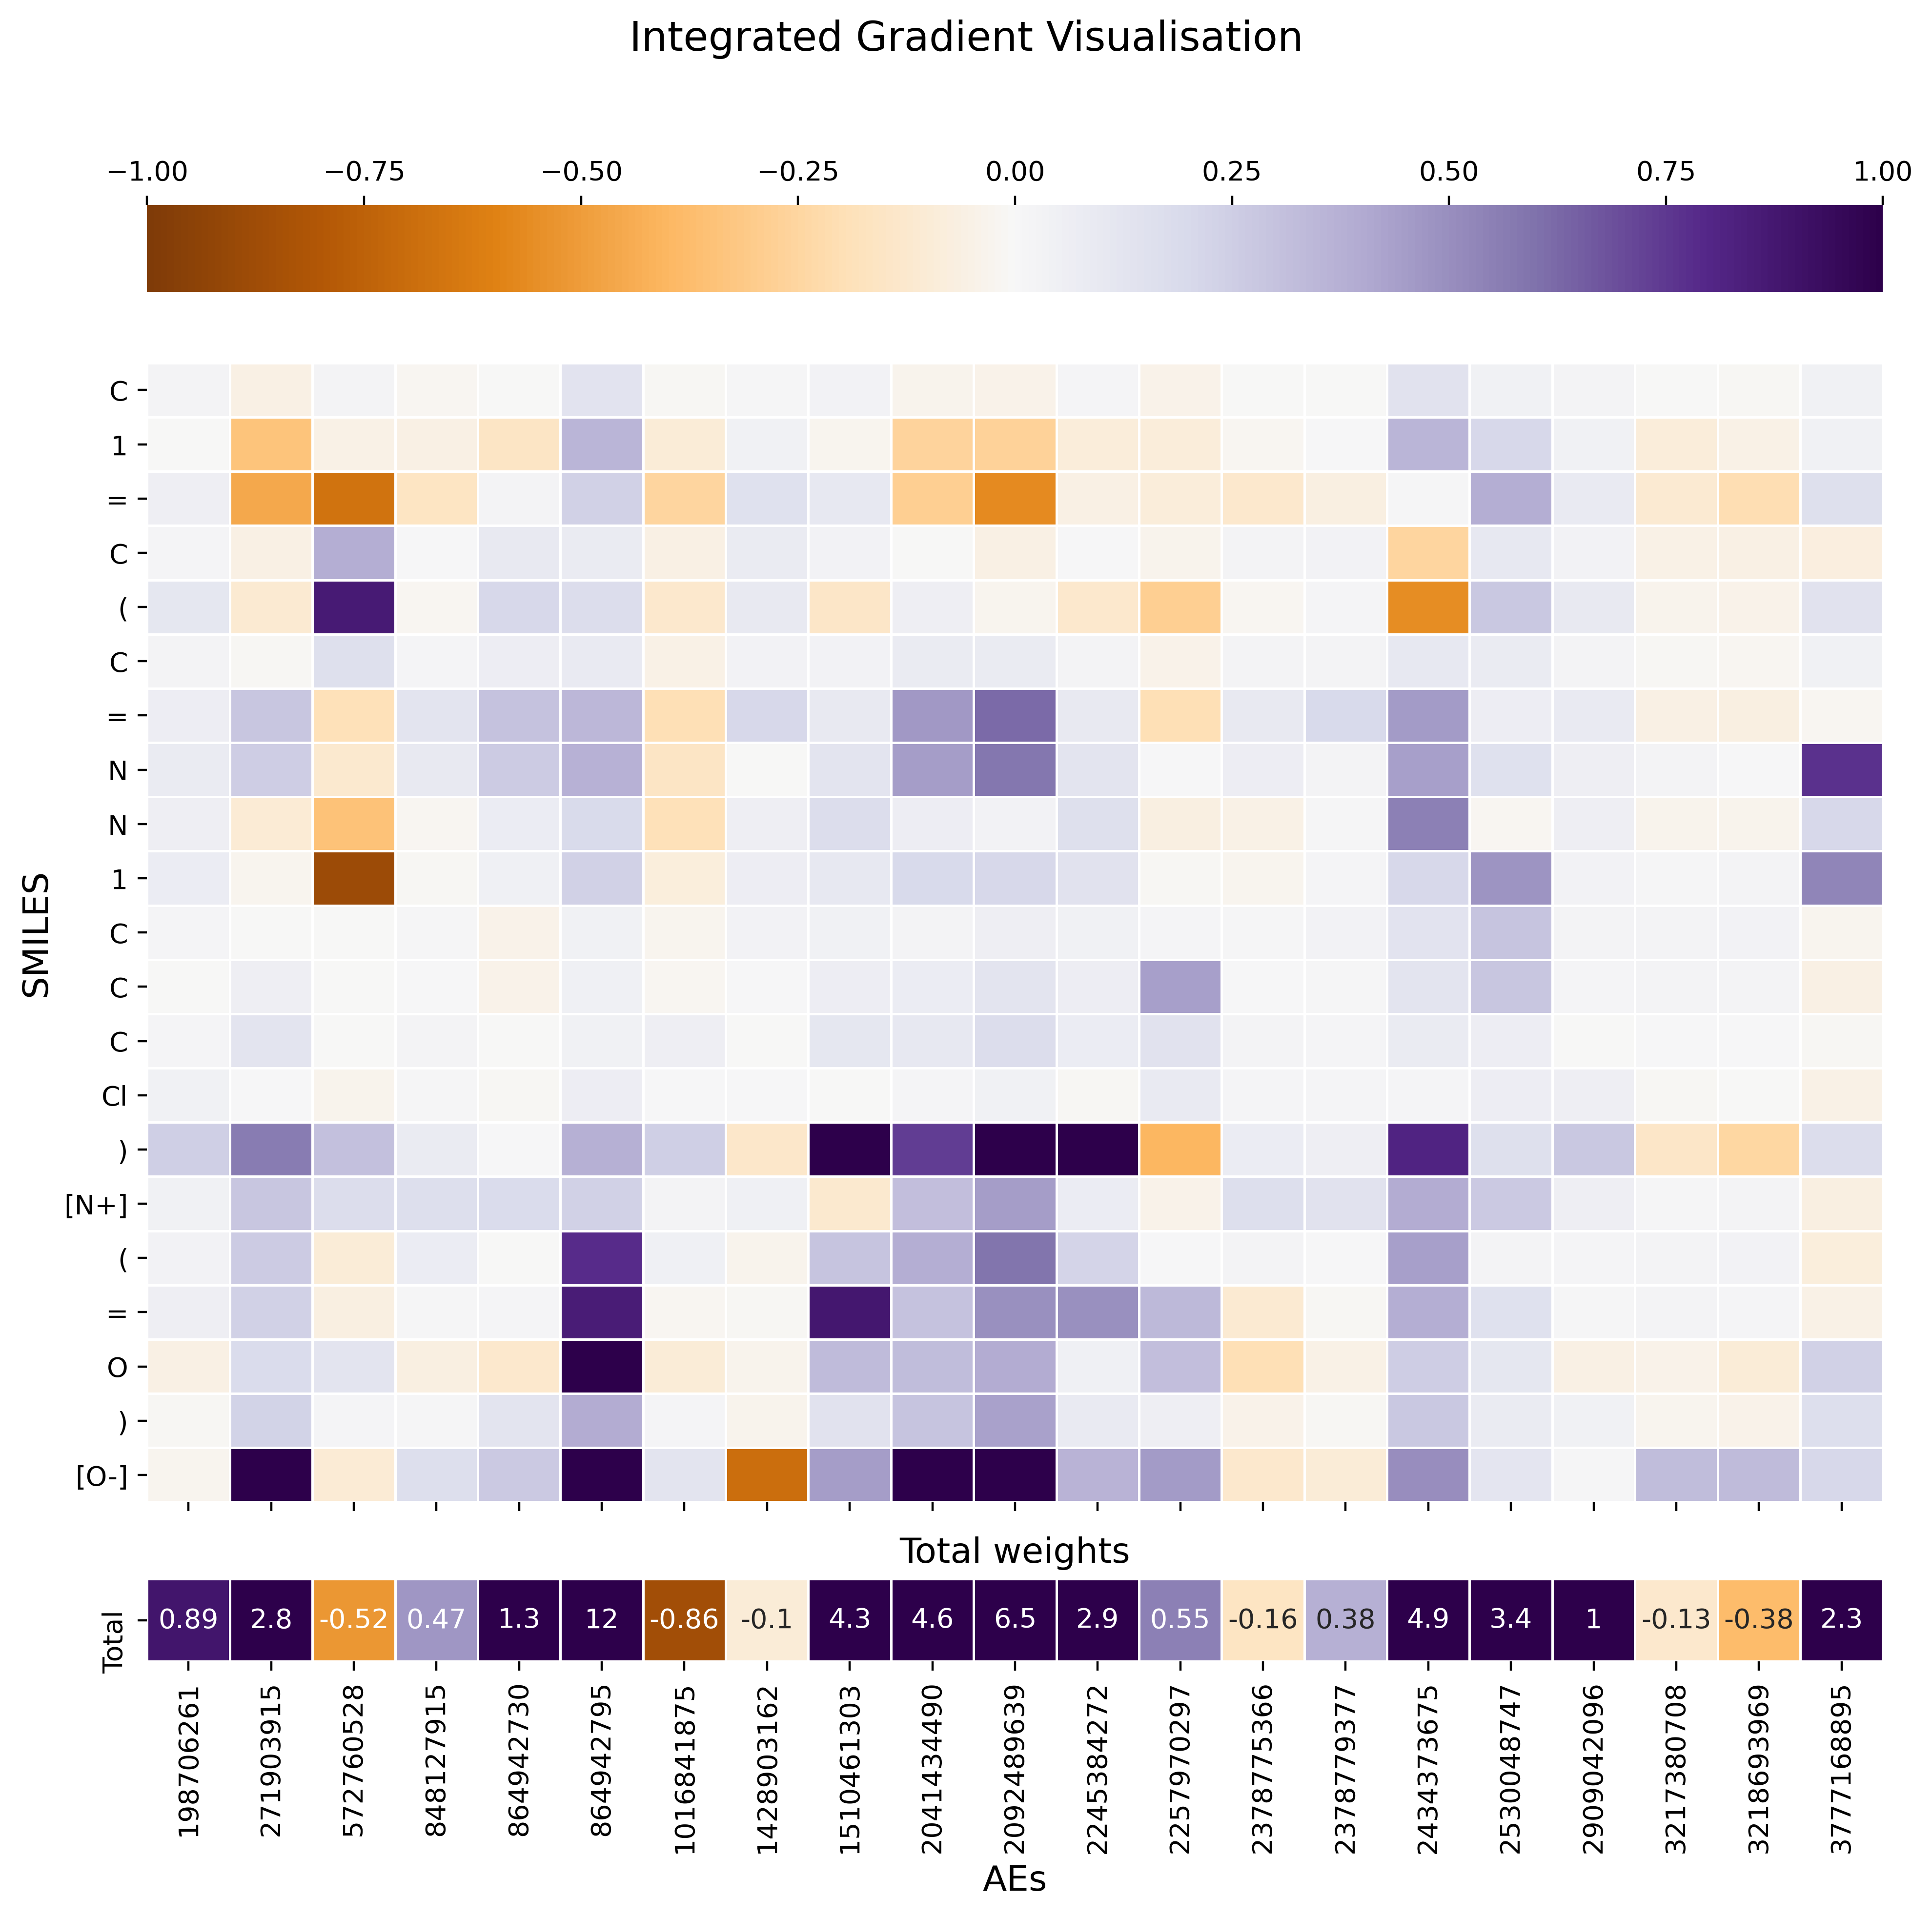

In [11]:
res = attribution(args, model, src, args.rank, n_step=100)
figig = IGplot(res, 'AEs', 'SMILES', savefig=False, return_fig=True)
# figig = IGplot(res, 'AEs', 'SMILES', f'IG_attribution.png', return_fig=True)


In [12]:
pred_smiles = res['pred'].replace(' ', '')
truth_smiles = trg.replace(' ', '')
tmol = Chem.MolFromSmiles(truth_smiles)
pmol = Chem.MolFromSmiles(pred_smiles)

res['Attn'] = attn
res['aes2smarts'] = getIdxSmarts(tmol)
res['pred_idx'] = Chem.MolToSmiles(mol_with_atom_index(pmol)) if pmol else None
res['ig_fig'] = figig
res['attn_fig'] = attnfig

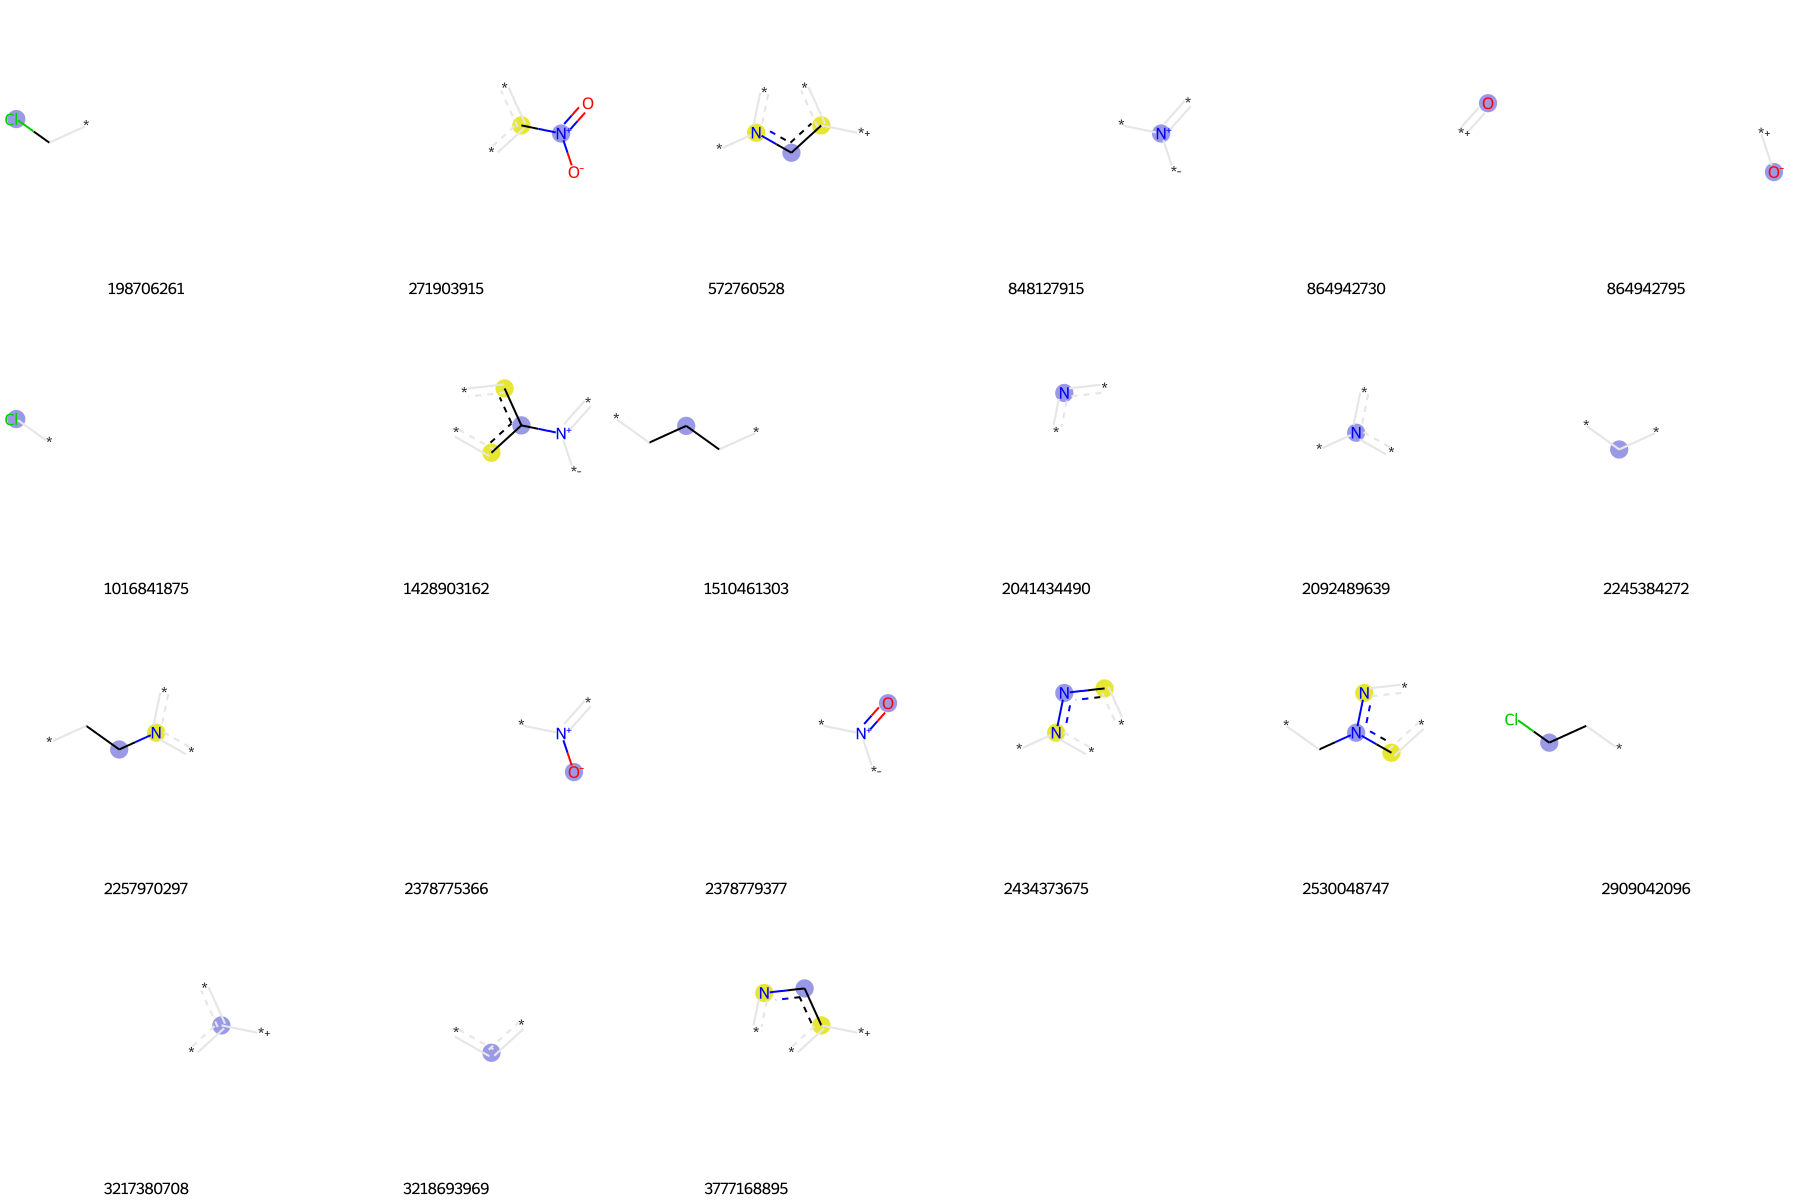

In [13]:
bi = {}
fp = GetMorganFingerprint(tmol, radius=1, bitInfo=bi)

tpls = [(tmol,x,bi) for x in fp.GetNonzeroElements()]
img = Chem.Draw.DrawMorganBits(tpls,
                         subImgSize=(300, 300), 
                         molsPerRow=6,
                         legends=[str(x) for x in fp.GetNonzeroElements()])

img
# img.save('interpretation_mol_bits.png')


In [14]:
trg

'C 1 = C ( C = N N 1 C C C Cl ) [N+] ( = O ) [O-]'

In [15]:
predicted

'C 1 = C ( C = N N 1 C C C Cl ) [N+] ( = O ) [O-]'

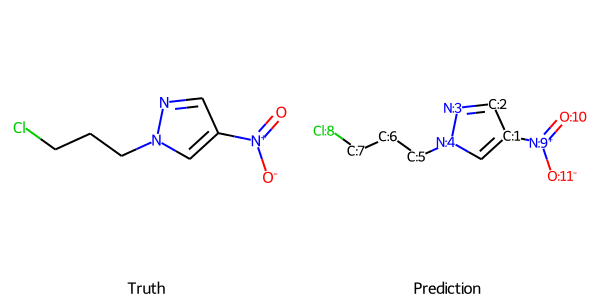

In [16]:
img = Chem.Draw.MolsToImage([tmol, pmol], subImgSize=(300, 300), legends=['Truth', 'Prediction'])
img

In [17]:
print(pred_smiles)
print(Chem.MolToSmiles(mol_with_atom_index(Chem.MolFromSmiles(pred_smiles))))
getIdxSmarts(Chem.MolFromSmiles(truth_smiles))

C1=C(C=NN1CCCCl)[N+](=O)[O-]
c1[c:1]([N+:9](=[O:10])[O-:11])[cH:2][n:3][n:4]1[CH2:5][CH2:6][CH2:7][Cl:8]


{198706261: (1, 8, '[Cl;!R;D1]-[CH2;!R;D2]'),
 271903915: (1, 9, '[[N+];!R;D3](=[O;!R;D1])(-[[O-];!R;D1])-[c;R;D3]'),
 572760528: (1, 0, '[cH;R;D2](:[c;R;D3]):[n;R;D3]'),
 848127915: (0, 9, '[[N+];!R;D3]'),
 864942730: (0, 10, '[O;!R;D1]'),
 864942795: (0, 11, '[[O-];!R;D1]'),
 1016841875: (0, 8, '[Cl;!R;D1]'),
 1428903162: (1, 1, '[c;R;D3](-[[N+];!R;D3])(:[cH;R;D2]):[cH;R;D2]'),
 1510461303: (1, 6, '[CH2;!R;D2](-[CH2;!R;D2])-[CH2;!R;D2]'),
 2041434490: (0, 3, '[n;R;D2]'),
 2092489639: (0, 4, '[n;R;D3]'),
 2245384272: (0, 5, '[CH2;!R;D2]'),
 2257970297: (1, 5, '[CH2;!R;D2](-[CH2;!R;D2])-[n;R;D3]'),
 2378775366: (1, 11, '[[O-];!R;D1]-[[N+];!R;D3]'),
 2378779377: (1, 10, '[O;!R;D1]=[[N+];!R;D3]'),
 2434373675: (1, 3, '[n;R;D2](:[cH;R;D2]):[n;R;D3]'),
 2530048747: (1, 4, '[n;R;D3](-[CH2;!R;D2])(:[cH;R;D2]):[n;R;D2]'),
 2909042096: (1, 7, '[CH2;!R;D2](-[CH2;!R;D2])-[Cl;!R;D1]'),
 3217380708: (0, 1, '[c;R;D3]'),
 3218693969: (0, 0, '[cH;R;D2]'),
 3777168895: (1, 2, '[cH;R;D2](:[c;R;D3]):[n;